# Project 3: Topic Classification using Naive Bayes

**Solution**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

## Grading
---
- Make sure to answer every part in every question.
 - There are 7 questions and one extra credit question. 
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).



In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [4]:
def Q1(num_examples=5):

  ### STUDENT START ###

  ##### Q1.1 #####

  # Iterates through the train_data dataset and displays the first 5 
  # documents with corresponding label. 
  for i in range(num_examples):
    print("---------------------------")
    print("Example:", i+1) 
    print("Label:", newsgroups_train.target_names[train_labels[i]])
    print("---------------------------")
    print(train_data[train_labels[i]])
    print()

  ### STUDENT END ###

Q1(5)

---------------------------
Example: 1
Label: comp.graphics
---------------------------


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.

---------------------------
Example: 2
Label: talk.religion.misc
---------------------------
I have a request for those who would like to see Charley Wingate
respond to the "Charley Challenges" (and judging from my e-mail, there
appear to be quite a few of you.)  

It is clear that Mr. Wingate intends to continue to post tangential or
unrelated articles while ingoring the Challenges themselves.  Between
the last two re-postings of the Challenges, I noted perhaps a dozen or
more posts by Mr. Wingate, none of which answered a single Challenge.  

It seems unmistakable to me th

### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [5]:
def Q2():

    ### STUDENT START ###

    ##### Q2.1.1 ######

    # Two transformations are performed: (1) the raw train_data is converted
    # to a vocab_list list data structure. (2) Using CountVectorizer, the list
    # is transformed to a new vocab_features vector matrix that contains all
    # unique words within the dataset. These are used subsequently in program.
    vocab_list = []
    for i in range(train_labels.shape[0]):
      vocab_list.append(train_data[i])
    vocab_matrix = CountVectorizer(analyzer = "word")
    vocab_transformed = vocab_matrix.fit_transform(vocab_list)
    vocab_features = vocab_matrix.get_feature_names_out()

    # vocab_features is generated above, and is a list that contains all 
    # unique words in the dataset. The length of the vocab_features list
    # returns the number of words (or size) of the train_data vocabulary.
    vocab_length = len(vocab_features)
    print('Q2.1.1: Size of vocabulary (word unigram):', vocab_length)

    ##### Q2.1.2 #####

    # vocab_transformed is generated above, and is a matrix containing the
    # number of occurrences of a word (in the vocabulary), for all documents.
    # The getnnz method counts the number of non-zero elements in the matrix.
    # To get the average number of non-zero features per document, getnnz is 
    # used to count all non-zero values in the matrix. The total is then 
    # divided by the total number of documents in the train_data dataset. 
    print('Q2.1.2: Average number non-zero features per example:', 
          (vocab_transformed.getnnz() / len(vocab_transformed.getnnz(1))))

    ##### Q2.1.3 #####

    # To calculate the fraction of non-zero entries in the matrix, getnnz is 
    # first used to count all non-zeros values in the matrix. The total is then
    # divided by the total number of entries in the matrix.  
    print('Q2.1.3: Fraction of non-zero entries in matrix:', 
          vocab_transformed.getnnz() / ((vocab_transformed.shape)[0] * (vocab_transformed.shape)[1]))

    ##### Q2.1.4 #####

    # vocab_features is generated above, and is an list containing all
    # unique words in the train_data dataset, in alphabetical order. The
    # zero and length of vocabulary minus one, are the index values that
    # display the first and last feature string in train_data vocabulary. 
    print('Q2.1.4: First and last feature strings:', 
          vocab_features[0], 'and', vocab_features[vocab_length - 1])

    # vocab_transformed_words is generated using CountVectorizer parameterized
    # with four pre-defined words. The output is a matrix containing the number
    # of documents containing the pre-defined words, for all documents in the
    # train_data dataset. The total is then divided by the total number of
    # documents in the train_data dataset to produce the average number of 
    # non-zero features per document.   
    vocab_matrix_words = CountVectorizer(vocabulary = ["atheism", "graphics", "space", "religion"])
    vocab_transformed_words = vocab_matrix_words.transform(vocab_list)
    print('Q2.2.1: Average number non-zero features per example:', 
          (vocab_transformed_words.getnnz() / len(vocab_transformed_words.getnnz(1))))

    ##### Q2.3.1 #####

    # vocab_features_ngram is a list generated using CountVectorizer and is 
    # parameterized to produce a matrix of character bigram and trigram 
    # feature vectors. The length of the vocab_features_ngram list returns 
    # the total number of bigram & trigram features in the new vocabulary. 
    vocab_matrix = CountVectorizer(analyzer = "char", ngram_range = (2,3)) 
    vocab_transformed = vocab_matrix.fit_transform(vocab_list)
    vocab_features_ngram = vocab_matrix.get_feature_names_out()
    print('Q2.3.1: Size of vocabulary (bigram & trigram):', len(vocab_features_ngram))

    ##### Q2.4.1 #####

    # vocab_features_ten is generated using CountVectorizer and is
    # parameterized to produce vocab_features_ten list that removes
    # words that appear less than 10 times in the vocabulary.  
    vocab_matrix_ten = CountVectorizer(analyzer = "word", min_df = 10)
    vocab_transformed_ten = vocab_matrix_ten.fit_transform(vocab_list)
    vocab_features_ten = vocab_matrix_ten.get_feature_names_out()
    print('Q2.4.1: Size of vocabulary (>10 pruned):', len(vocab_features_ten))

    ##### Q2.5.1 #####

    # vocab_features_train_length is generated using CountVectorizer, and 
    # contains list of all unique words in the train_data dataset. The total 
    # is used to compare difference in vocabulary size from dev_data dataset. 
    vocab_list_train = []
    for i in range(train_labels.shape[0]):
      vocab_list_train.append(train_data[i])
    vocab_matrix = CountVectorizer(analyzer = "word")
    vocab_transformed = vocab_matrix.fit_transform(vocab_list_train)
    vocab_features_train = vocab_matrix.get_feature_names_out()
    vocab_features_train_length = len(vocab_features_train)

    # vocab_features_dev_length is generated using CountVectorizer, and 
    # contains list of all unique words in the dev_data dataset. The total
    # is used to compare difference in vocabulary size from train_data dataset. 
    vocab_list_dev = []
    for i in range(dev_labels.shape[0]):
      vocab_list_dev.append(dev_data[i])
    vocab_matrix = CountVectorizer(analyzer = "word")
    vocab_transformed = vocab_matrix.fit_transform(vocab_list_dev)
    vocab_features_dev = vocab_matrix.get_feature_names_out()
    vocab_features_dev_length = len(vocab_features_dev)

    # The vocabulary sizes from train_data and dev_data datasets are used to
    # calculate the fraction of vocabulary in dev_data missing from the
    # train_data vocabulary. 
    print("Q2.5.1: Fraction of dev vocabulary missing from train vocabulary:", 
          (1 - (vocab_features_dev_length / vocab_features_train_length)))

    ### STUDENT END ###

Q2()

Q2.1.1: Size of vocabulary (word unigram): 26879
Q2.1.2: Average number non-zero features per example: 96.70599803343165
Q2.1.3: Fraction of non-zero entries in matrix: 0.0035978272269590263
Q2.1.4: First and last feature strings: 00 and zyxel
Q2.2.1: Average number non-zero features per example: 0.26843657817109146
Q2.3.1: Size of vocabulary (bigram & trigram): 35478
Q2.4.1: Size of vocabulary (>10 pruned): 3064
Q2.5.1: Fraction of dev vocabulary missing from train vocabulary: 0.395587633468507


### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [6]:
def Q3():

    ### STUDENT START ###

    ##### Q3.1 #####

    # Transforms training and development data to matrices of word unigram
    # feature vectors using CountVectorizer. The transformed data is used in 
    # subsequent sections to train models. 
    vocab_matrix = CountVectorizer(analyzer = "word")
    fit_train = vocab_matrix.fit_transform(train_data)
    transform_dev = vocab_matrix.transform(dev_data)

    ##### Q3.2 #####

    # Using a list of pre-defined values of k, multiple KNN models are 
    # produced using fitted train_data, and predictions made using transformed
    # transformed dev_data from above. The corresponding f1 score is calculated
    # for each model,  with best f1 / value of k identified.  
    print("-------------------- Q3.2 --------------------") 
    k = [1, 3, 5, 7, 9, 11, 13, 15] # Pre-defined k values.

    knn_results_list = []
    for i in k:
      knn_model = KNeighborsClassifier(n_neighbors = i)
      knn_model.fit(fit_train, train_labels)
      model_prediction = knn_model.predict(transform_dev)
      f1_score = metrics.f1_score(dev_labels, model_prediction, average = "weighted")
      print("[k]:", i, "  \t [f1 score]:", f1_score) 
      knn_results_list.append(f1_score)
      best_k = max(knn_results_list)
      best_k_index = knn_results_list.index(best_k)
    print()
    print("Best f1 score:", max(knn_results_list))
    print("Corresponding k:", k[best_k_index]) 

    ##### Q3.3 #####

    # Using a list of pre-defined values of alpha, multiple MultinomialNB
    # models are gproduced using fitted train_data, and predictions made
    # using transformed dev_data from above. The corresponding f1 score is 
    # calculated for each model, with best f1 / value of alpha identified.
    print()
    print("-------------------- Q3.3 --------------------")
    alpha = [0.0001, 0.001, 0.01, 0.1, 1.0, 1.5, 3.0, 10.0] # Pre-defined alphas. 

    mnb_results_list = []
    for i in alpha:
      mnb_model = MultinomialNB(alpha = i)
      mnb_model.fit(fit_train, train_labels)
      model_prediction = mnb_model.predict(transform_dev)
      f1_score = metrics.f1_score(dev_labels, model_prediction, average = "weighted")
      print("[alpha]:", i, " ", " \t  [f1 score]:", f1_score)
      mnb_results_list.append(f1_score)
      best_alpha = max(mnb_results_list)
      best_alpha_index = mnb_results_list.index(best_alpha)
    print()
    print("Best f1 score:", max(mnb_results_list))
    print("Corresponding alpha:", alpha[best_alpha_index])

    ##### Q3.4 #####

    # Using a list of pre-defined values of C, multiple Logistic Regression
    # models are produced using fitted train_data, and predictions made using
    # transformed dev_data from above. The corresponding f1 score is calculated
    # for each model and used for analysis purposes. Further, the coefficients 
    # of each model are used to compute the sum of squares that correspond 
    # to the C values used for the epoch. 
    print()
    print("-------------------- Q3.4 --------------------")
    c = [0.0001, 0.001, 0.01, 0.1, 1.0, 1.5, 3.0, 10.0] # Pre-defined c.

    best_c_list = []
    for i in c:
      lr_model = LogisticRegression(C = i, solver = "liblinear", multi_class = "auto")
      lr_model.fit(fit_train, train_labels)
      model_prediction = lr_model.predict(transform_dev)
      f1_score = metrics.f1_score(dev_labels, model_prediction, average = "weighted")
      model_coefficients = lr_model.coef_ # Gets weights by each label.
      best_c_list.append(f1_score)
      best_c = max(best_c_list)
      best_c_index = best_c_list.index(best_c)
    
      sum_of_sq_list = []
      for row in range(model_coefficients.shape[0]):
        sum_of_sq = 0.0
        for col in range(model_coefficients.shape[1]):
          sum_of_sq += model_coefficients[row][col] * model_coefficients[row][col]
        sum_of_sq_list.append(sum_of_sq)
      print("[C]:", i, "  \t [f1 score]:", f1_score, "  [Sum-Of-Squares]:", sum_of_sq_list)
    print()
    print("Best f1 score:", max(best_c_list))
    print("Corresponding c:", c[best_c_index])

    ### STUDENT END ###

Q3()

-------------------- Q3.2 --------------------
[k]: 1   	 [f1 score]: 0.3805030018531525
[k]: 3   	 [f1 score]: 0.4084150225437623
[k]: 5   	 [f1 score]: 0.4287607236218357
[k]: 7   	 [f1 score]: 0.45047910006117586
[k]: 9   	 [f1 score]: 0.4365666176198027
[k]: 11   	 [f1 score]: 0.4266108018696209
[k]: 13   	 [f1 score]: 0.42404338833763805
[k]: 15   	 [f1 score]: 0.4326339805547054

Best f1 score: 0.45047910006117586
Corresponding k: 7

-------------------- Q3.3 --------------------
[alpha]: 0.0001    	  [f1 score]: 0.7628348704826354
[alpha]: 0.001    	  [f1 score]: 0.7702518836155706
[alpha]: 0.01    	  [f1 score]: 0.7751663218544357
[alpha]: 0.1    	  [f1 score]: 0.7903052385098862
[alpha]: 1.0    	  [f1 score]: 0.7777320236017224
[alpha]: 1.5    	  [f1 score]: 0.7698782977061732
[alpha]: 3.0    	  [f1 score]: 0.7540837683726805
[alpha]: 10.0    	  [f1 score]: 0.6674814338256576

Best f1 score: 0.7903052385098862
Corresponding alpha: 0.1

-------------------- Q3.4 ---------------

**ANSWER:** (See below ): 

**Q3.5:** The KNN algorithm calculates distance between prediction data and all the training data, in order to classify the prediction data to a given label (i.e. documents with similar words will have similar labels). However, the KNN algorithm suffers from sparse datasets, such as the train_data dataset. From Q2, we see a raw vocabularly size of 27,869 unique words and an average of 97 unique words per document. In other words, the dataset is very sparse, given a vast number of words in the vocabulary, and only a small fraction of those words in each document. The documents also contain numerous common/stop words that are shared across each label, further confusing the knn algorithm and explaining the poor performance across the 8 k values used. 

**Q3.6:** In general, the Naive Bayes algorithm performs better with less data while Logistic Regression algorithm performs better with linear data. The relatively small dataset (ony 2034 documents) coupled with the sparsity of the dataset (26,876 vocabulary size) likely explains why then Naive Bayes algorithm performed better than Logistic Regression. However, given a larger dataset (and additional pre-processing of the data), Logistic Regression may perform better than Naive Bayes. 

**Q3.7:** As the value of C increases, we observe the sum-of-square values also increasing. This is expected, as C is the inverse of the regularization parameter, and the sum-of-square weights are inversely correlated with the regularization parameter. In other words, as the value of C gets larger, there is less regulation (i.e. the training data is trusted more) while lower values of C tell the algorithm/model not to "listen" to very large parameters it may see (i.e. the training data may not be representative of the actual data it will see). 



### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


In [7]:
def Q4():
  
    ### STUDENT START ###

    ##### Q4.1 #####

    # Transforms the train_data and dev_data datasets to a unique list of 
    # word bigram feature vectors. The transformed lists are then used to 
    # produce models in the subsequent sections.    
    vocab_matrix = CountVectorizer(analyzer = "word", ngram_range = (2,2))
    fit_train = vocab_matrix.fit_transform(train_data)
    transform_dev = vocab_matrix.transform(dev_data)
    vocab_features = vocab_matrix.get_feature_names_out()

    ##### Q4.2 #####

    # Produces a logistic regression model that takes in fit_train from above
    # and uses pre-defined parameters for the logistics regression model.
    lr_model = LogisticRegression(C = 0.5, solver = "liblinear", multi_class = "auto")
    lr_model.fit(fit_train, train_labels)

    # Creates a matrix of weights for each label. The list is sorted using
    # argsort, which enables retrieval of the top five bigrams from each label
    # that is stored in the weights_matrix list.  
    print("-------------------- Q4.2 (Top 5 bigrams by label) --------------------")
    print()
    weights_matrix = []
    for i in range(len(newsgroups_train.target_names)):
        model_coefficients = lr_model.coef_[i,]
        coefficients_list = np.array(model_coefficients)
        sorted_index = coefficients_list.argsort()[-5:][::-1] # Gets top 5 weights.
        weights_matrix[i*5:(i+1)*5] = sorted_index 
        print("Label:", newsgroups_train.target_names[i])
        print("Bigrams:", vocab_features[sorted_index]) 
        print()
    
    ##### Q4.3 #####

    # Displays a table of weights for the top 5 word bi-grams and their labels.
    # The weights are calculated above for Q4.2, and a pandas dataframe is used 
    # to display the results in grid format.  
    print("-------------- Q4.3 (Table of weights by feature & label) --------------")
    print()
    dataframe = {}          
    index = vocab_features[weights_matrix]
    for i in range(len(newsgroups_train.target_names)):
        dataframe[newsgroups_train.target_names[i]] = lr_model.coef_[i, weights_matrix]
    table = pd.DataFrame(data = dataframe, index = index) # Constructs table
    print(table)    
        
  ### STUDENT END ###

Q4()

-------------------- Q4.2 (Top 5 bigrams by label) --------------------

Label: alt.atheism
Bigrams: ['claim that' 'cheers kent' 'was just' 'you are' 'are you']

Label: comp.graphics
Bigrams: ['looking for' 'in advance' 'comp graphics' 'out there' 'is there']

Label: sci.space
Bigrams: ['the space' 'the moon' 'sci space' 'and such' 'it was']

Label: talk.religion.misc
Bigrams: ['the fbi' 'cheers kent' 'ignorance is' 'but he' 'of jesus']

-------------- Q4.3 (Table of weights by feature & label) --------------

               alt.atheism  comp.graphics  sci.space  talk.religion.misc
claim that        0.605549      -0.199067  -0.274345           -0.140364
cheers kent       0.555720      -0.697918  -0.663766            0.534808
was just          0.482050      -0.131418  -0.128882           -0.227469
you are           0.472740      -0.279894  -0.481305            0.028373
are you           0.446953      -0.248257  -0.097135           -0.305625
looking for      -0.630341       1.108375  -0.

**ANSWER:** For the top 5 features (by weight) that have the highest impact towards classifying a document to a label, we are surprised to see bigrams that do not correspond to the actual label. As an example, "are you" (for atheism), "is there" (for graphics), "it was" (for space), and "but he" (for religion), have no relationship to their respective labels, yet they are features directly responsible (have the highest weights) for classifying documents to their respective labels. Additionally, the bigram "cheers kent" is seen in both alt.atheism and talk.religion.misc, which suggests some overlap. Though surprising, the results are expected, as the weights represent the frequency of bigrams/features across the entire training dataset, and does not contain any preprocessing, such as removal of common/stop words or other pruning to remove noise. In summary, while some of the top bigrams/features are surprising, the insights help us understand why certain misclassifications will occur on future document predictions. 

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [8]:
# The better_preprocessor function applies various processing on the dataset
# in order to eliminate 'noise' and improve the models overall ability to
# classify documents to their correct label. 
def better_preprocessor(s):

    # List of stop words from the nltk library, used to filer out common
    # words from the training dataset before producing a model. 
    stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", 
    "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 
    'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', 
    "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 
    'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 
    'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 
    'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 
    'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 
    'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',
    'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 
    'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 
    'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 
    'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', 
    "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 
    "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 
    'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
    'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 
    'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
    "weren't", 'won', "won't", 'wouldn', "wouldn't"]
    
    s1 = s.lower() # Transforms all characters to lowercase.
    #s2 = re.sub("[^a-zA-Z]", " ", s1) # Converts all text to letters only.
    #s3 = re.sub('\d+', '0', s2) # Converts all numbers to digit 0.
    s4 = s1.split() # Separates string to list
    s5 = []

    # This builds a new list of words that does not contain any stop words.
    # The new list is used to produce a logistic regression model in 
    # subsequent sections below. 
    for word in s4:
      if word not in stop_words:
        s5.append(word)
    s6 = ' '.join(s5)

    return s6

def Q5():

  ### STUDENT START ###

  ##### Q5.1 #####

    # Transforms the train_data dataset to unique list of features
    # (word unigrams) which is then fitted on the dev_data dataset. 
    # The results of fit_train feed into logistic regression model below.
    vocab_matrix = CountVectorizer(analyzer = "word")
    fit_train = vocab_matrix.fit_transform(train_data)
    transform_dev = vocab_matrix.transform(dev_data)
    vocabulary_features = vocab_matrix.get_feature_names_out()

    # Produces a logistic regression model using pre-defined parameters for 
    # model and non-processed training data from above. The model is used for
    # prediction on development data, with the corresponding f1 score
    # displayed for comparison with pre-processed training data. 
    lr_model = LogisticRegression(C = 0.5, solver = "liblinear", multi_class = "auto")
    lr_model.fit(fit_train, train_labels)
    model_prediction = lr_model.predict(transform_dev)
    f1_score = metrics.f1_score(dev_labels, model_prediction, average = "weighted")
    print("--- Q5.1 (No Processing) ---")
    print("f1 Score:", f1_score)
    print("Vocabulary Size:", len(vocabulary_features))
    print()
    
    ##### Q5.2 #####

    # Transforms the train_data dataset using better_preprocessor function, 
    # which pre-processes the training data in order to improve the models
    # ability to accurately predict an example to the right label / category.
    vocabulary_matrix_processed = CountVectorizer(analyzer = "word")
    processor = np.vectorize(better_preprocessor)
    fit_train_processed = vocabulary_matrix_processed.fit_transform(processor(train_data))
    transform_dev_processed = vocabulary_matrix_processed.transform(processor(dev_data))
    vocabulary_features_processed = np.array(vocabulary_matrix_processed.get_feature_names_out())

    # Produces a logistic regression model using pre-defined parameters for 
    # model and pre-processed training data from above. The model is used for
    # prediction on development data, with the corresponding f1 score
    # displayed for comparison with non-processed training data. 
    lr_model_processed = LogisticRegression(C = 0.5, solver = "liblinear", multi_class = "auto")
    lr_model_processed.fit(fit_train_processed, train_labels)
    model_prediction_processed = lr_model_processed.predict(transform_dev_processed)
    f1_score_processed = metrics.f1_score(dev_labels, model_prediction_processed, average = "weighted")
    print("--- Q5.2 (With Processing) ---")
    print("f1 Score:", f1_score_processed)
    print("Vocabulary Size:", len(vocabulary_features_processed))

    print()
    print("---------- Summary ----------")
    print("f1 improvement:", f1_score_processed - f1_score)
    print("Vocabulary reduction:", (len(vocabulary_features) - len(vocabulary_features_processed)))

  ### STUDENT END ###

Q5()

--- Q5.1 (No Processing) ---
f1 Score: 0.7084739776490449
Vocabulary Size: 26879

--- Q5.2 (With Processing) ---
f1 Score: 0.7225770108397608
Vocabulary Size: 26876

---------- Summary ----------
f1 improvement: 0.01410303319071593
Vocabulary reduction: 3


**ANSWER:** Without pre-processing the data, we achieved an f1 score of [0.7084739776490449] on a vocabulary size of [26879]. By pre-processing the data, our best f1 score increased by [0.01410303319071593] with a vocabulary reduction of only [3] words. The pre-processing included converting all strings to lowercase, splitting strings to a list, followed by removing stop words obtained from an nltk library. We experimented with other pre-processing, which included removal of apostrophe, converting all digits to 0, and applying stemming to consolidate like words (i.e. applying -> apply). Although we did not achieve an f1 score improvement of 0.02, we were also surprised that our vocabulary reduction (3 words) resulted in the greatest improvement over the other techniques we experimented with. 

### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

--------------------- Q6.1.2: L2 Regularization & F1-score --------------------

[C]: 0.05        [f1 score]: 0.6494001908701528

------------ Q6.1.3: L1 Regularization, Vocabulary Size & F1-score ------------

[C]: 0.001    	 [f1 score]: 0.24053020446463066 	[Vocabulary size]: 3
[C]: 0.01    	 [f1 score]: 0.39111849362777806 	[Vocabulary size]: 16
[C]: 0.03    	 [f1 score]: 0.5047905779357489 	[Vocabulary size]: 68
[C]: 0.05    	 [f1 score]: 0.5553852030270408 	[Vocabulary size]: 120
[C]: 0.1    	 [f1 score]: 0.6316685129027481 	[Vocabulary size]: 211
[C]: 0.3    	 [f1 score]: 0.6782530072642177 	[Vocabulary size]: 512
[C]: 0.5    	 [f1 score]: 0.6711544832986958 	[Vocabulary size]: 740
[C]: 1    	 [f1 score]: 0.6748765595215318 	[Vocabulary size]: 1129
[C]: 10    	 [f1 score]: 0.6608337802908129 	[Vocabulary size]: 3353
[C]: 50    	 [f1 score]: 0.6361085188956481 	[Vocabulary size]: 5963
[C]: 100    	 [f1 score]: 0.6172024520897746 	[Vocabulary size]: 10121
[C]: 1000    	 [f1 score]:

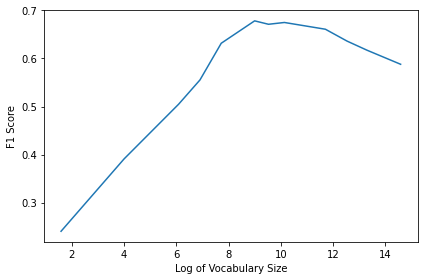

In [9]:
import math # Required to take log of vocabulary size below.

# This function takes in two lists: (1) size of new vocabulary following the
# generation of each logistic regression model with l1 penalty and (2) the 
# corresponding f1 score associated with the new vocabulary list. The results
# are used to plot a grid showing relationship between log(new vocabulary) and
# corresponding f1 score. 
def plotting(x_log_vocabulary, y_f1_score):

  fig, ax1 = plt.subplots()
  ax1.set_xlabel('Log of Vocabulary Size')
  ax1.set_ylabel('F1 Score')
  ax1.plot(x_log_vocabulary, y_f1_score)
  fig.tight_layout()
  plt.show()

def Q6():

    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###

    # Predefined values of c for logistic regression model.
    c_values = [0.001, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 10, 50, 100, 1000]

    ##### Q6.1.1 #####    

    # Transforms train_data and dev_data datasets to new vectorized matrix
    # using CountVectorizer. The matrix is used to produce a logistic 
    # regression model with l1 regularization below.
    vectorize = CountVectorizer()
    fit_train = vectorize.fit_transform(train_data)
    transform_dev = vectorize.transform(dev_data)
    features = vectorize.get_feature_names_out()

    # stores weights non-zero vocab

    # Produces a logistic regression model with l1 penalty. The resulting
    # model coefficients that are not equal to zero (not removed by model)
    # are appended to a new non_zero_weights list, which is used as input
    # to a secondary logistic regression model with l2 penalty below. 
    non_zero_weights = []
    for c in c_values:
      
        # 1. train LR model with L1 regularization - we'll call this LR1
        lr1 = LogisticRegression(C = c, penalty = "l1", solver = "liblinear", tol = 0.015)
        lr1.fit(fit_train, train_labels)

        # 2. enumerate through LR1 model and find .coef_ != 0 - these are the features that are used 
        non_zeros_lr1 = np.sum(lr1.coef_ != 0, axis = 0) != 0
        non_zero_weights.append(non_zeros_lr1)

    # Transforms non_zero_weights list to new_vocabulary_lr1_reduction list
    # which contains the new vocabulary of words following L1 reduction. This
    # list is used to train a logistic regression model (L2 regularization)
    # in the subsequent sections. 
    new_vocabulary_lr1_reduction = []
    for col in range(len(non_zeros_lr1)):
      if (non_zero_weights[6][col] == True):
        new_vocabulary_lr1_reduction.append(features[col])

    # Transforms the new_vocabulary_lr1_reduction list to new vectorized
    # matrix using CountVectorizer. The matrix is used to produce a logistic
    # regression model with l2 regularization below. 
    new_vectorize = CountVectorizer(vocabulary = new_vocabulary_lr1_reduction) 
    new_fit_train = new_vectorize.fit_transform(train_data)
    new_transform_dev = new_vectorize.transform(dev_data)

    ##### Q6.1.2 #####

    # 5. train LR model with L2 regularization - we'll call this LR2
    lr2 = LogisticRegression(C = 0.5, penalty = 'l2', solver = "liblinear", tol = 0.015)
    lr2.fit(new_fit_train, train_labels)
    model_prediction_l2 = lr2.predict(new_transform_dev)

    # 6. calculate f1 score of LR2
    f1_score_l2 = metrics.f1_score(dev_labels, model_prediction_l2, average = "macro")
    print("--------------------- Q6.1.2: L2 Regularization & F1-score --------------------")
    print()
    print("[C]: 0.05        [f1 score]:", f1_score_l2, )
    print()

    #### #6.1.3 ####

    # Using the vectorized fit_train data above, a logistis regression model
    # with l1 regularization is produced for multiple values of c. The results
    # include the f1-score of each model (given C), the reduced vocabulary size
    # and two lists - x_log_vocabulary (the log of vocabulary size) and 
    # y_f1_score - which are used to plot a graph in subsequent section. 
    count = 0
    x_log_vocabulary = []
    y_f1_score = []
    print("------------ Q6.1.3: L1 Regularization, Vocabulary Size & F1-score ------------")
    print()
    for c in c_values:    
        lr1 = LogisticRegression(C = c, penalty = "l1", solver = "liblinear", tol = 0.015)
        lr1.fit(fit_train, train_labels)
        model_prediction_lr1 = lr1.predict(transform_dev)
        f1_score_lr1 = metrics.f1_score(dev_labels, model_prediction_lr1, average = "macro")
        y_f1_score.append(f1_score_lr1)
        x_log_vocabulary.append(math.log2(np.sum(non_zero_weights[count])))
        print("[C]:", c , "   \t [f1 score]:", f1_score_lr1, "\t[Vocabulary size]:", np.sum(non_zero_weights[count]))
        count += 1
    
    # 7. Plot f1 score vs log(vocabulary size)
    print()
    print("------------------- Q6.2: F1-Score vs Log Vocabulary Size -------------------")
    print()
    plotting(x_log_vocabulary, y_f1_score)
       
  ### STUDENT END ###

Q6()

**ANSWER:** In general, we observe an increasing f1 score as the size of the training data increases. However, when the vocabulary size becomes too large (and scattered), the f1 score begins to decrease. The observation is expected, as a reasonable amount of training data (i.e. words) is required for a model to become more generalized / handle a variety of words in a document. The decreasing f1 score (as vocabulary size increases) is counterintuitive, but is also expected. One potential explanation is increasing vocabularies increases chance of word overlap (i.e. in Q4, 'cheers kent' was weighted similarly for two different labels). Another potential explanation is word sparsity - as we saw in Q5, we can pre-process the text by removing stop words, applying stemming or similar, which aims to reduce vocabulary by removing noisy data. 

Results: The logistic regression model with l2 penalty (no reduction) and c value of [0.05] and a vocabulary size of [26,879] produced an f1 score of [0.6494001908701528]. At the same regularization strength, we see a logistic regression model with l1 penalty, we see a better f1 score of [0.6711544832986958] using a reduced vocabulary of only 740 words. 

### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [10]:
def Q7():

    ### STUDENT START ###

    ##### Q7.1 #####

    # Transforms the train_data and dev_data datasets using TfidfVectorizer. 
    # This produces a matrix identifying the unique words across each category
    # that make it unique to a particulary category (i.e. god is unique word
    # for religion category). The results are used in subsequent sections below.
    vocab_matrix = TfidfVectorizer()
    fit_train = vocab_matrix.fit_transform(train_data)
    transform_dev = vocab_matrix.transform(dev_data)
    
    # Produces a logistic regression model using pre-defined parameters for 
    # model and transformed training data using TfidfVectorizer. The model is
    # then used for prediction on development data, and calculates f1 score.
    lr_model = LogisticRegression(C = 100, solver = "liblinear", multi_class = "auto")
    lr_model.fit(fit_train, train_labels)
    model_prediction = lr_model.predict(transform_dev)
    print("Q7.1: f1 Score:", metrics.f1_score(dev_labels, model_prediction, average = "macro"))

    ##### Q7.2 #####

    # The predicted probabilities of the model are calculated and used to 
    # calculate the R values for all values in the dev dataset. R is calculated 
    # from the maximum predicted probability divided by predicted probability
    # of the correct label - the top 3 R values and corresponding documents
    # are displayed. 
    print("Q7.2: Top 3 documents with highest R value: ")
    print()
    probabilities = lr_model.predict_proba(transform_dev)
    R_values = np.array([probabilities[i, model_prediction[i]] / probabilities[i, dev_labels[i]] for i in range(len(dev_labels))])
    sorted_index = R_values.argsort()[-3:][::-1]

    # Using the R value calculations above, each documents predicted label,
    # actual label and R value are included for each document. 
    for i in sorted_index:
        print("----------------------------------")
        print("Predicted Label:", newsgroups_train.target_names[model_prediction[i]])
        print("Actual Label:", newsgroups_train.target_names[dev_labels[i]])
        print("R-value:", R_values[i])
        print("----------------------------------")
        print()
        print(dev_data[i])
        print()

    ### STUDENT END ###

Q7()

Q7.1: f1 Score: 0.7473913101645842
Q7.2: Top 3 documents with highest R value: 

----------------------------------
Predicted Label: comp.graphics
Actual Label: talk.religion.misc
R-value: 929.3571373334202
----------------------------------

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual co

**ANSWER:**

The TF-IDF algorithm appears to struggle with classifying documents describing how to send a religious book (The Book of Mormon) via email or FTP. There could be a number of reasons that contribute to the misclassification. One such explanation is the training data contained the word 'Mormon' uniquely across documents labeld 'comp.graphics', however, the same word more unique/prevenlant across documents labeled 'talk.religion.misc' - thus leading to the misclassification. This can potentially be solved through mechanisms that lower weight to religious words (i.e. Mormon) or using n-grams in order to give the model more 'context'. 

A separate but interesting example is the classifier misclassified a 'alt.atheism' labeled document to a 'talk.religious.misc' document. While the mechanisms that separate religion from atheism are itself, challenging, I would have thought the model would classify as 'sci.space', given the word 'space' towards the end of the document. 

### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.

In [11]:
def Q8():
  
  ### STUDENT START ###
  pass
  ### STUDENT END ### 

Q8()

# Citations and Resources:

1.   Collaborated with Satya Srinivas and CB Bangalore
2.   https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html 
3.   https://www.mathworks.com/help/matlab/ref/nnz.html
4.   https://www.youtube.com/watch?v=RZYjsw6P4nI 
5.   https://medium.com/swlh/natural-language-processing-in-python-with-code-part-ii-18c8742762a4 
6.   https://medium.com/@meetnandu996/natural-language-processing-in-python-with-code-part-i-7736e3b112ab
7.   https://towardsdatascience.com/word2vec-explained-49c52b4ccb71 
8.   https://www.youtube.com/watch?v=vN5cNN2-HWE 
9.   https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistical-modeling/regression/how-to/fit-binary-logistic-model/interpret-the-results/all-statistics-and-graphs/coefficients-and-regression-equation/
10.  https://towardsdatascience.com/k-nearest-neighbors-k-nn-explained-8959f97a8632
11.  https://www.youtube.com/watch?v=O2L2Uv9pdDA
12.  https://www.youtube.com/watch?v=yIYKR4sgzI8
13.  https://www.youtube.com/watch?v=vN5cNN2-HWE
14.  https://analyticsindiamag.com/naive-bayes-why-is-it-favoured-for-text-related-tasks/
15.  https://towardsdatascience.com/text-classification-using-k-nearest-neighbors-46fa8a77acc5 
16.  https://www.sciencedirect.com/science/article/pii/S2666412722000101
17.  https://www.youtube.com/watch?v=OymqCnh-APA
18.  https://realpython.com/nltk-nlp-python/         


